In [1]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
train = pd.read_csv("C:/Users/sahu1/usa housing/housing_train.csv")

## The first thing to do when encountering new data is to run the .info() function, which will collect information about the dataset (feature names, data type, number of non-zero values).

## EDA AND DATA PREPARATION

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(train.shape)
print(train.dtypes.value_counts())

(1460, 81)
object     43
int64      35
float64     3
dtype: int64


> ### At first fill NAN values.

In [5]:
# number of nan values 
pd.DataFrame(train.isna().sum()).round(2).sort_values(by=0, ascending=False).head(10)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81
GarageFinish,81


In [6]:
# number of nan values  in percent
pd.DataFrame(train.isna().mean()*100).round(2).sort_values(by=0, ascending=False).head(10)

,0
PoolQC,99.52
MiscFeature,96.30
Alley,93.77
Fence,80.75
FireplaceQu,47.26
LotFrontage,17.74
GarageYrBlt,5.55
GarageCond,5.55
GarageType,5.55
GarageFinish,5.55


In [7]:
# remove features with gaps of more than 40%
train = train.drop(columns=train.columns[train.isna().mean() > 0.40])

In [8]:
# function for filling nan values: mode, meadian and mean 
def get_value(X, column, mode='mean', value=0, columns_for_reg=None): 

    if mode == 'median':
        X.loc[X[X[column].isna()].index ,column] = X[column].median()    
    
    elif mode == 'mean':
        X.loc[X[X[column].isna()].index, column] = X[column].mean()  
      
    elif mode == 'mode':
        X.loc[X[X[column].isna()].index, column] = X[column].mode()[0]

    return X.head()

In [9]:
for i in train.columns[train.dtypes == 'int64']:
      get_value(train, column= i, mode='median')

for i in train.columns[train.dtypes == 'float64']:
      get_value(train, column= i, mode='mean')

for i in train.columns[train.dtypes == 'object']:
      get_value(train, column= i, mode='mode')

In [10]:
(train.isna().mean() * 100).round(2)

Id               0.0
MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
                ... 
MoSold           0.0
YrSold           0.0
SaleType         0.0
SaleCondition    0.0
SalePrice        0.0
Length: 76, dtype: float64

>  ### We handled empty values.

## OUTLIERS

In [11]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(random_state=42)
y_outliers = iso.fit_predict(train.select_dtypes(include=['int64', 'float64']))

for i in range(len(y_outliers)):
    if y_outliers[i] == -1:
        train.drop(i, inplace = True)

In [12]:
train.shape

(1400, 76)

In [13]:
# separate dataset:
train_object = train.select_dtypes(include=['object'])
train_num = train.select_dtypes(include=['int64', 'float64'])

In [14]:
# let's delete this features due to imbalance
print(train_object[['Utilities']].value_counts())
print(train_object[['Street']].value_counts())

Utilities
AllPub       1399
NoSeWa          1
dtype: int64
Street
Pave      1396
Grvl         4
dtype: int64


In [15]:
train_object = train_object.drop(columns=['Utilities', 'Street'])

In [16]:
# encode object features
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()


for i in train_object.columns:
      train_object[i] = ord_enc.fit_transform(train_object[[i]])

In [17]:
train_object.astype('int')

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,3,3,3,4,0,5,2,2,0,5,...,4,2,6,1,1,4,4,2,8,4
1,3,3,3,2,0,24,1,2,0,2,...,4,3,6,1,1,4,4,2,8,4
2,3,0,3,4,0,5,2,2,0,5,...,4,2,6,1,1,4,4,2,8,4
3,3,0,3,0,0,6,2,2,0,5,...,4,2,6,5,2,4,4,2,8,0
4,3,0,3,2,0,15,2,2,0,5,...,4,2,6,1,1,4,4,2,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1,3,3,4,0,21,2,2,0,2,...,4,2,6,1,1,4,4,2,8,4
1455,3,3,3,4,0,8,2,2,0,5,...,4,3,6,1,1,4,4,2,8,4
1456,3,3,3,4,0,14,2,2,0,2,...,4,3,2,1,2,4,4,2,8,4
1458,3,3,3,4,0,12,2,2,0,2,...,0,2,6,1,2,4,4,2,8,4


In [18]:
train_object['SalePrice'] = train_num['SalePrice']
train_object.head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,3.0,3.0,3.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,...,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0,208500
1,3.0,3.0,3.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,...,3.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0,181500
2,3.0,0.0,3.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,...,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0,223500
3,3.0,0.0,3.0,0.0,0.0,6.0,2.0,2.0,0.0,5.0,...,2.0,6.0,5.0,2.0,4.0,4.0,2.0,8.0,0.0,140000
4,3.0,0.0,3.0,2.0,0.0,15.0,2.0,2.0,0.0,5.0,...,2.0,6.0,1.0,1.0,4.0,4.0,2.0,8.0,4.0,250000


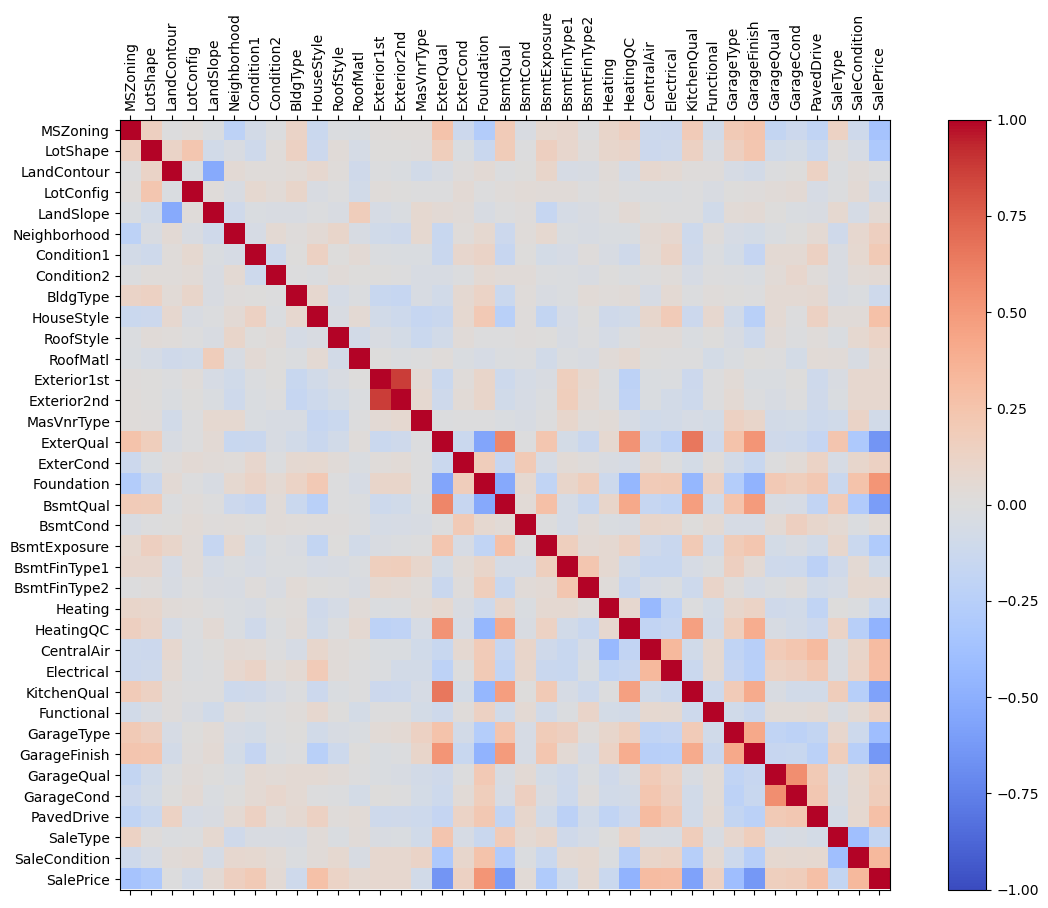

In [19]:
import seaborn as sbs
import matplotlib.pyplot as plt

corr = train_object.corr(method = 'spearman')
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_object.columns)
ax.set_yticklabels(train_object.columns)
plt.show()

> ### We can see high correlation between features:

* Exterior1st-Exterior2nd
* KitchenQual-ExterQual
* BsmtQual-ExterQual
* GarageCond-GarageQual
* BsmtQual-KitchenQual
* Foundation-YearBuilt

In [20]:
# correlation betwee SalePrice and object features
(train_object.corr()['SalePrice']*100).sort_values(ascending=False)

SalePrice        100.000000
Foundation        43.434957
CentralAir        26.500795
Electrical        24.876586
PavedDrive        24.823240
SaleCondition     24.204308
Neighborhood      20.031474
HouseStyle        19.262102
RoofStyle         18.314367
ExterCond         14.765067
GarageCond        14.596431
GarageQual        13.687635
Exterior2nd       12.554779
Functional        12.459567
Exterior1st       12.407410
Condition1        11.832885
BsmtFinType2       5.750825
RoofMatl           5.466770
BsmtCond           5.264803
LandSlope          4.290576
LandContour        2.203348
Condition2         1.107734
MasVnrType        -0.024766
SaleType          -5.891562
LotConfig         -5.906961
BldgType          -6.723230
BsmtFinType1      -9.584435
Heating          -12.090965
MSZoning         -21.202731
LotShape         -25.916584
BsmtExposure     -29.815967
GarageType       -35.233429
HeatingQC        -42.337119
GarageFinish     -57.265647
KitchenQual      -58.983649
BsmtQual         -63

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(train_object.values, i) for i in range(train_object.shape[1])]
vif['variable'] = train_object.columns

vif.sort_values(by='VIF', ascending=False).head(10)

,VIF,variable
7,122.708908,Condition2
32,87.599051,GarageCond
31,67.591337,GarageQual
12,41.698808,Exterior1st
15,40.488234,ExterQual
13,40.044952,Exterior2nd
28,37.127213,Functional
16,31.104932,ExterCond
22,29.039360,BsmtFinType2
0,27.907582,MSZoning


In [22]:
train_object = train_object.drop(columns=['GarageCond', 'ExterQual', 'Exterior1st', 'Condition2'])

In [23]:
train_object.shape

(1400, 33)

> ### Prepare data int and float type

In [24]:
train_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1.0,60,65.0,8450.0,7,5,2003,2003,196.0,706.0,...,0,61,0,0,0,0,0,2,2008,208500
1,2.0,20,80.0,9600.0,6,8,1976,1976,0.0,978.0,...,298,0,0,0,0,0,0,5,2007,181500
2,3.0,60,68.0,11250.0,7,5,2001,2002,162.0,486.0,...,0,42,0,0,0,0,0,9,2008,223500
3,4.0,70,60.0,9550.0,7,5,1915,1970,0.0,216.0,...,0,35,272,0,0,0,0,2,2006,140000
4,5.0,60,84.0,14260.0,8,5,2000,2000,350.0,655.0,...,192,84,0,0,0,0,0,12,2008,250000


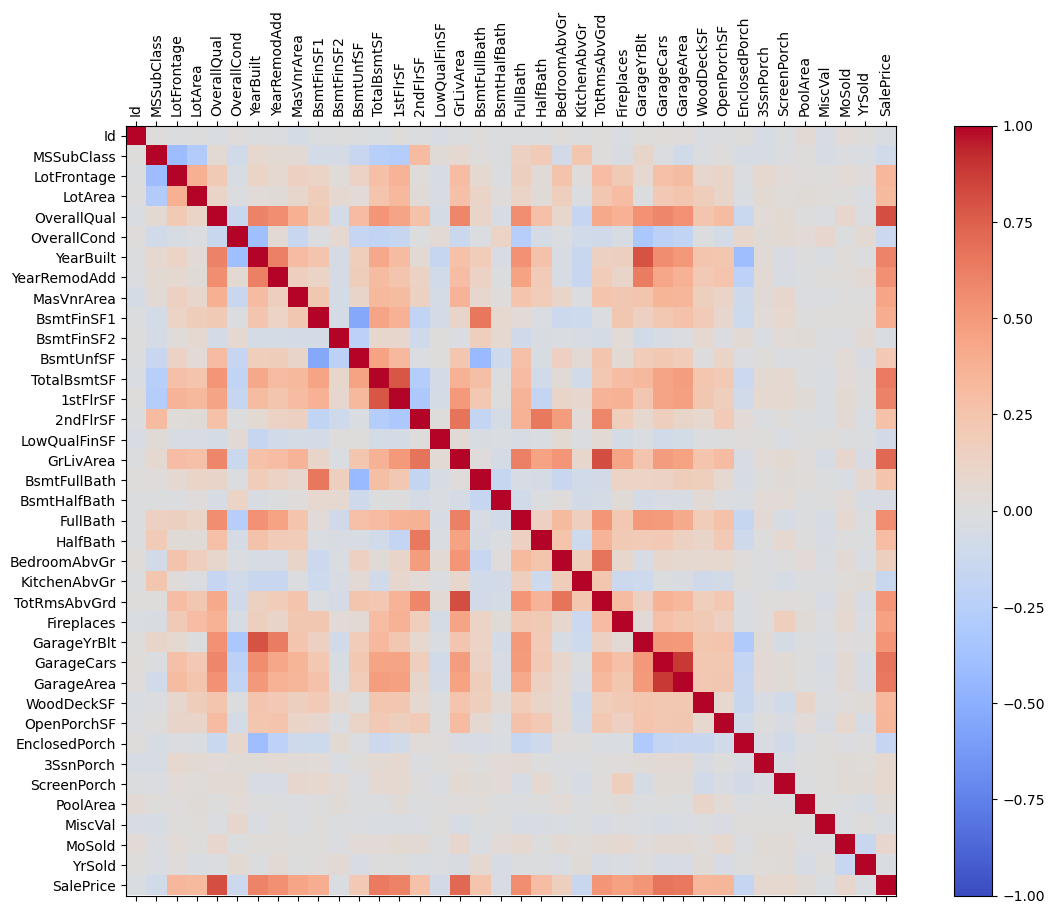

In [25]:
import seaborn as sbs
import matplotlib.pyplot as plt

corr = train_num.corr()
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_num.columns)
ax.set_yticklabels(train_num.columns)
plt.show()

> ### We can see high correlation between features:

* GarageCars-GarageArea
* 1stFlrSF-TotalBsmtSF
* GarageYrBlt-YearBuilt
* GrLivArea-TotRmsAbvGrd

In [26]:
(train_object.corr()['SalePrice']*100).sort_values(ascending=False)

SalePrice        100.000000
Foundation        43.434957
CentralAir        26.500795
Electrical        24.876586
PavedDrive        24.823240
SaleCondition     24.204308
Neighborhood      20.031474
HouseStyle        19.262102
RoofStyle         18.314367
ExterCond         14.765067
GarageQual        13.687635
Exterior2nd       12.554779
Functional        12.459567
Condition1        11.832885
BsmtFinType2       5.750825
RoofMatl           5.466770
BsmtCond           5.264803
LandSlope          4.290576
LandContour        2.203348
MasVnrType        -0.024766
SaleType          -5.891562
LotConfig         -5.906961
BldgType          -6.723230
BsmtFinType1      -9.584435
Heating          -12.090965
MSZoning         -21.202731
LotShape         -25.916584
BsmtExposure     -29.815967
GarageType       -35.233429
HeatingQC        -42.337119
GarageFinish     -57.265647
KitchenQual      -58.983649
BsmtQual         -63.021646
Name: SalePrice, dtype: float64

In [27]:
# delete some of them
train_num = train_num[['SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold']]



In [28]:
for i in ['GrLivArea', '1stFlrSF', 'LotArea']:
    train_num[i] = np.log(train_num[i])

train_num.loc[train_num['TotalBsmtSF']>0,'TotalBsmtSF'] = np.log(train_num['TotalBsmtSF'])
train_num.loc[train_num['GarageArea']>0,'GarageArea'] = np.log(train_num['GarageArea'])

In [29]:
train_num.describe()

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,...,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,176289.527857,56.175000,69.348814,9.085360,6.070714,5.580714,1971.905714,1984.788571,98.753426,429.049286,...,5.823031,92.005714,44.707857,20.690714,3.555714,13.420714,1.401429,31.602857,6.334286,2007.813571
std,68910.780682,41.758968,20.471165,0.486910,1.323888,1.077709,29.518020,20.722259,168.407685,419.021744,...,1.394542,121.652618,61.504136,57.461322,29.930724,50.763852,30.407929,436.591171,2.699847,1.330981
min,34900.000000,20.000000,21.000000,7.170120,2.000000,2.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,129500.000000,20.000000,60.000000,8.922658,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,...,5.789194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,161000.000000,50.000000,70.049958,9.144414,6.000000,5.000000,1973.000000,1994.000000,0.000000,380.500000,...,6.162261,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,210000.000000,70.000000,78.000000,9.341061,7.000000,6.000000,2001.000000,2004.000000,160.000000,699.250000,...,6.356108,168.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,465000.000000,190.000000,313.000000,11.653982,10.000000,9.000000,2010.000000,2010.000000,1600.000000,1880.000000,...,7.237059,736.000000,523.000000,330.000000,508.000000,396.000000,738.000000,15500.000000,12.000000,2010.000000


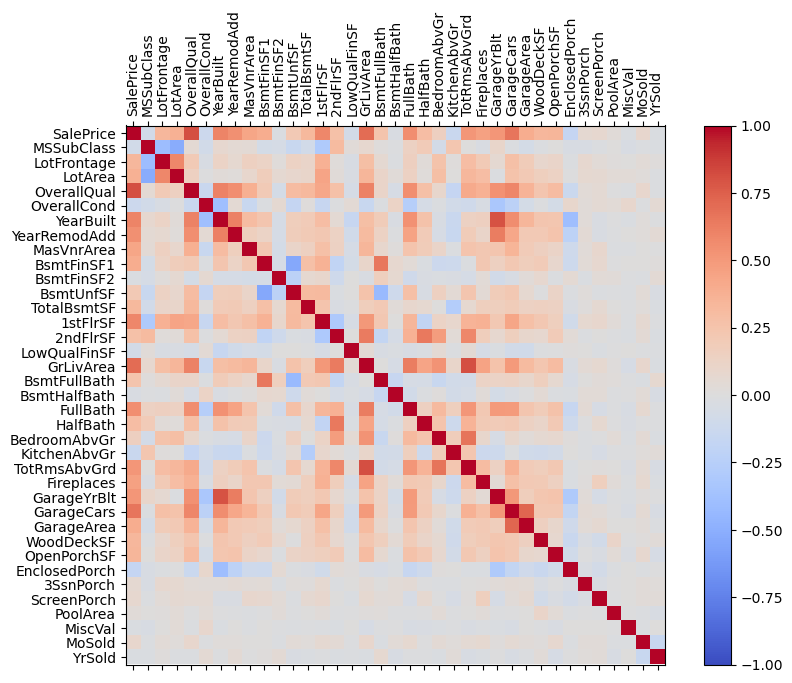

In [30]:
import seaborn as sbs
import matplotlib.pyplot as plt

corr = train_num.corr()
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(train_num.columns)
ax.set_yticklabels(train_num.columns)
plt.show()

In [31]:
X = pd.concat([train_num.drop(columns='SalePrice'), train_object.drop(columns='SalePrice')], axis=1)
y = train['SalePrice']

### RANDOMIZESEARCHCV  TO FIND OPTIMAL PARAMETERS

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV

In [33]:
models=[
    {'name':'LR',"model": Lasso(), 'params':{ 'fit_intercept':[True,False], 'normalize':[True,False]}},
    {'name':'Lasso',"model": Lasso(), 'params':{ 'alpha': (np.logspace(-8, 8, 100))}},
    {'name':'Ridge',"model": Ridge(), 'params':{ 'solver':['svd', 'cholesky', 'lsqr', 'sag'], 'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 'fit_intercept':[True, False], 'normalize':[True, False]}},
    {'name':'BRidge',"model": BayesianRidge(), 'params':{ 'alpha_init':[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.9], 'lambda_init': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-9]}},
    {'name':'RF',"model": RandomForestRegressor(), 'params':{ 'bootstrap': [True], 'max_depth': [5, 10, 20, 50, 100], 'min_samples_leaf': [2, 3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [5, 10, 20, 30, 100]}},
    {'name':'EN',"model": ElasticNet(), 'params':{ 'max_iter': [1, 5, 10], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': np.arange(0.0, 1.0, 0.1)}},
    {'name':'KNN',"model": KNeighborsRegressor(), 'params':{ 'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'weights': ['uniform','distance'],'p':[1,2,5]}},
    {'name':'GBR',"model": GradientBoostingRegressor(), 'params':{'learning_rate': [0.01,0.02,0.03,0.04],'subsample' : [0.9, 0.5, 0.2, 0.1],'n_estimators' : [2, 5, 10,50,100, 150], 'max_depth' : [2,4,6,8,10]}}
    ]

In [34]:
res=[]
for v in  models:
    res.append((v['name'], RandomizedSearchCV(v['model'], v['params'], cv=10).fit(X, y)))


for r in res:
    print(r[0], r[1].best_score_, r[1].best_params_)

LR 0.8884448650704793 {'normalize': True, 'fit_intercept': True}
Lasso 0.8880706659804494 {'alpha': 5.336699231206324}
Ridge 0.8881708554938937 {'solver': 'cholesky', 'normalize': False, 'fit_intercept': False, 'alpha': 0.0001}
BRidge 0.8864460184687024 {'lambda_init': 1e-06, 'alpha_init': 1.3}
RF 0.8819208018327345 {'n_estimators': 30, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}
EN 0.8841534571571726 {'max_iter': 10, 'l1_ratio': 0.9, 'alpha': 0.1}
KNN 0.7624221734398546 {'weights': 'distance', 'p': 1, 'n_neighbors': 12}
GBR 0.9010910278627595 {'subsample': 0.9, 'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.04}


## MODEL TRANING

In [35]:
pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [36]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

X_train, X_test, y_train, y_test
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# MODELING

# 1. LinerRegression

lr = LinearRegression(normalize=True, fit_intercept=True)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# 2. Ridge

ridge = Ridge(solver='svd', normalize=True, fit_intercept=False, alpha=0.01, random_state=42)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# 3. Lasso

lasso = Lasso(alpha = 0.18738174228603868, random_state=42)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

# 4. Bayesian

bayesian = BayesianRidge(lambda_init=0.1, alpha_init=1.3)
bayesian.fit(X_train, y_train)
bayesian_pred = bayesian.predict(X_test)

# 5. ElasticNet

en = ElasticNet(max_iter=10, l1_ratio=0.6000000000000001, alpha=0.01, random_state=42)
en.fit(X_train, y_train)
en_pred = en.predict(X_test)

# 5. RandomForest

rf = RandomForestRegressor(n_estimators=30, min_samples_split=10, min_samples_leaf=5, max_depth= 100, bootstrap=True, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# 6. KNeighborsRegressor

knn = KNeighborsRegressor(weights='distance', p=1, n_neighbors=8)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)


# 7. GradientBoostingRegressor
gbr = GradientBoostingRegressor(subsample=0.2, n_estimators=150, max_depth=8, learning_rate=0.04, random_state=42)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)



from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from termcolor import colored as cl
from sklearn.metrics import explained_variance_score as evs

print(f"mae=  : LR={mean_absolute_error(y_test,lr_pred):.3f}, Ridge={mean_absolute_error(y_test,ridge_pred):.3f}, Lasso={mean_absolute_error(y_test,lasso_pred):.3f}, Bayesian={mean_absolute_error(y_test,bayesian_pred):.3f}, ElasticNet={mean_absolute_error(y_test,en_pred):.3f}, RandomForest={mean_absolute_error(y_test,rf_pred):.3f}, Knn={mean_absolute_error(y_test,knn_pred):.3f}, GBR={mean_absolute_error(y_test,gbr_pred):.3f}")
print(f"mse=  : LR={mean_squared_error(y_test,lr_pred):.3f}, Ridge={mean_squared_error(y_test,ridge_pred):.3f}, Lasso={mean_squared_error(y_test,lasso_pred):.3f}, Bayesian={mean_squared_error(y_test,bayesian_pred):.3f}, ElasticNet={mean_squared_error(y_test,en_pred):.3f}, RandomForest={mean_squared_error(y_test,rf_pred):.3f}, Knn={mean_squared_error(y_test,knn_pred):.3f}, GBR={mean_squared_error(y_test,gbr_pred):.3f}")
print(f"r2=   : LR={r2_score(y_test,lr_pred):.3f}, Ridge={r2_score(y_test,ridge_pred):.3f}, Lasso={r2_score(y_test,lasso_pred):.3f}, Bayesian={r2_score(y_test,bayesian_pred):.3f}, ElasticNet={r2_score(y_test,en_pred):.3f}, RandomForest={r2_score(y_test,rf_pred):.3f}, Knn={r2_score(y_test,knn_pred):.3f}, GBR={r2_score(y_test,gbr_pred):.3f}")


mae=  : LR=14149.421, Ridge=177105.971, Lasso=14148.951, Bayesian=14184.995, ElasticNet=14971.855, RandomForest=12905.337, Knn=14218.562, GBR=11308.012
mse=  : LR=329506260.344, Ridge=31695922286.347, Lasso=329489932.794, Bayesian=332991250.122, ElasticNet=365956360.223, RandomForest=313652327.113, Knn=425293002.758, GBR=230025964.522
r2=   : LR=0.916, Ridge=-7.055, Lasso=0.916, Bayesian=0.915, ElasticNet=0.907, RandomForest=0.920, Knn=0.892, GBR=0.942


> ### GradientBoostingRegressor algorithm shows better perfomance accors all metrics.

In [37]:
print(cl('Explained Variance Score of LinearRegression model is {}'.format(r2_score(y_test, lr_pred)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_pred)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Lasso model is {}'.format(evs(y_test, lasso_pred)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_pred)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of ElasticNet is {}'.format(evs(y_test, en_pred)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of RandomForestRegressor is {}'.format(evs(y_test, rf_pred)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of KNeighborsRegressor is {}'.format(evs(y_test, knn_pred)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')
print(cl('Explained Variance Score of GradientBoostingRegressor is {}'.format(evs(y_test, gbr_pred)), attrs = ['bold']))
print('-------------------------------------------------------------------------------')


Explained Variance Score of LinearRegression model is 0.916260255704342
-------------------------------------------------------------------------------
Explained Variance Score of Ridge model is 0.9162879631158889
-------------------------------------------------------------------------------
Explained Variance Score of Lasso model is 0.9162913698009038
-------------------------------------------------------------------------------
Explained Variance Score of Bayesian model is 0.9154194082187513
-------------------------------------------------------------------------------
Explained Variance Score of ElasticNet is 0.9070025739819481
-------------------------------------------------------------------------------
Explained Variance Score of RandomForestRegressor is 0.9203726028946153
-------------------------------------------------------------------------------
Explained Variance Score of KNeighborsRegressor is 0.8958720847697468
--------------------------------------------------------

In [38]:
import pickle
pickle.dump(gbr, open('gbr.pkl', 'wb'))

In [39]:
pickled_model = pickle.load(open('gbr.pkl', 'rb'))

In [40]:
import pickle

file_path = 'gbr.pkl'

# Load the content of the .pkl file
with open(file_path, 'rb') as file:
    content = pickle.load(file)

# Print or inspect the loaded content
print(content)


GradientBoostingRegressor(learning_rate=0.04, max_depth=8, n_estimators=150,
                          random_state=42, subsample=0.2)


In [42]:
prediction_data = pd.read_csv("C:/Users/sahu1/usa housing/housing_train.csv")

In [43]:
prediction_data = prediction_data[['Neighborhood', 'Condition1','YearBuilt','BldgType','BedroomAbvGr', 'KitchenAbvGr','FullBath', 'GarageCars', 'LotArea']]
prediction_data

,Neighborhood,Condition1,YearBuilt,BldgType,BedroomAbvGr,KitchenAbvGr,FullBath,GarageCars,LotArea
0,CollgCr,Norm,2003,1Fam,3,1,2,2,8450
1,Veenker,Feedr,1976,1Fam,3,1,2,2,9600
2,CollgCr,Norm,2001,1Fam,3,1,2,2,11250
3,Crawfor,Norm,1915,1Fam,3,1,1,3,9550
4,NoRidge,Norm,2000,1Fam,4,1,2,3,14260
...,...,...,...,...,...,...,...,...,...
1455,Gilbert,Norm,1999,1Fam,3,1,2,2,7917
1456,NWAmes,Norm,1978,1Fam,3,1,2,2,13175
1457,Crawfor,Norm,1941,1Fam,4,1,2,1,9042
1458,NAmes,Norm,1950,1Fam,2,1,1,1,9717


In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
# Create a list of string features
string_features = ['Neighborhood', 'Condition1', 'BldgType']

In [45]:
# Encode the string features using one-hot encoding
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(train[string_features])

In [53]:
import pickle
pickle.dump(encoder, open('encoder.pkl', 'wb'))

In [54]:
pick_model = pickle.load(open('encoder.pkl', 'rb'))
pick_model

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [55]:
numerical_features = ['YearBuilt','BedroomAbvGr', 'KitchenAbvGr','FullBath', 'GarageCars', 'LotArea']
features = np.concatenate((encoded_features, train[numerical_features]), axis=1)

In [56]:
target = train['SalePrice']

In [57]:
# Create and train the GradientBoostingRegressor model
gbr = GradientBoostingRegressor()
gbr.fit(features, target)

GradientBoostingRegressor()

In [58]:
# Prepare new instance for prediction
new_instance = pd.DataFrame({
    'Neighborhood': ['CollgCr'],
    'Condition1': ['Norm'],
    'YearBuilt': [2001],
    'BldgType': ['1Fam'],
    'BedroomAbvGr': [3],
    'KitchenAbvGr': [2],
    'FullBath': [2],
    'GarageCars': [2],
    'LotArea': [9045]


})


In [59]:
encoded_instance = encoder.transform(new_instance[string_features])

In [60]:
instance_features = pd.concat([pd.DataFrame(encoded_instance), new_instance[numerical_features]], axis=1)

In [61]:
predicted_prices = gbr.predict(instance_features)
print(predicted_prices)

[182157.09321961]


## PREPARE TEST DATASET

In [38]:
test = pd.read_csv('C:/Users/Acer/Documents/Mini project 2/house-prices-advanced-regression-techniques/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [39]:
test = test.drop(columns=test.columns[test.isna().mean() > 0.40])

for i in test.columns[test.dtypes == 'int64']:
      get_value(test, column= i, mode='median')

for i in test.columns[test.dtypes == 'float64']:
      get_value(test, column= i, mode='mean')

for i in test.columns[test.dtypes == 'object']:
      get_value(test, column= i, mode='mode')
  

test = test.drop(columns=['Utilities', 'Street', 'GarageCond', 'ExterQual', 'Exterior1st', 'Condition2'])

test_object = test.select_dtypes(include=['object'])
test_num = test.select_dtypes(include=['int64', 'float64'])

from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()


for i in test_object.columns:
      test_object[i] = ord_enc.fit_transform(test_object[[i]])


test_object.astype('int')

test_num = test_num[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold']]


for i in ['GrLivArea', '1stFlrSF', 'LotArea']:
    test_num[i] = np.log(test_num[i])

test_num.loc[test_num['TotalBsmtSF']>0,'TotalBsmtSF'] = np.log(test_num['TotalBsmtSF'])
test_num.loc[test_num['GarageArea']>0,'GarageArea'] = np.log(test_num['GarageArea'])


X_test = pd.concat([test_num, test_object], axis=1)

In [40]:
X.shape

(1400, 68)

In [41]:
X_test.shape

(1459, 68)

In [48]:
X.shape

(1400, 68)

In [49]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X, y)
X_test = scaler.transform(X_test)

# MODELING

# 1. LinerRegression

lr = LinearRegression(normalize=True, fit_intercept=True)
lr.fit(X_train, y)
lr_pred = lr.predict(X_test)

# 2. Ridge

ridge = Ridge(solver='cholesky', normalize=False, fit_intercept=True, alpha=0.001)
ridge.fit(X_train, y)
ridge_pred = ridge.predict(X_test)

# 3. Lasso

lasso = Lasso(alpha = 0.004534878508128591)
lasso.fit(X_train, y)
lasso_pred = lasso.predict(X_test)

# 4. Bayesian

bayesian = BayesianRidge(lambda_init=0.1, alpha_init=1.3)
bayesian.fit(X_train, y)
bayesian_pred = bayesian.predict(X_test)

# 5. ElasticNet

en = ElasticNet(max_iter=10, l1_ratio=0.6000000000000001, alpha=0.01)
en.fit(X_train, y)
en_pred = en.predict(X_test)

# 5. RandomForest

rf = RandomForestRegressor(n_estimators=30, min_samples_split=10, min_samples_leaf=5, max_depth= 100, bootstrap=True)
rf.fit(X_train, y)
rf_pred = rf.predict(X_test)

# 6. KNeighborsRegressor

knn = KNeighborsRegressor(weights='uniform', p=1, n_neighbors=15)
knn.fit(X_train, y)
knn_pred = knn.predict(X_test)


# 7. GradientBoostingRegressor
gbr = GradientBoostingRegressor(subsample=0.5, n_estimators=150, max_depth=6, learning_rate=0.04)
gbr.fit(X_train, y)
gbr_pred = gbr.predict(X_test)




from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

print (f"mae=  : LR={mean_absolute_error(y_submission,lr_pred):.3f}, Ridge={mean_absolute_error(y_submission,ridge_pred):.3f}, Lasso={mean_absolute_error(y_submission,lasso_pred):.3f}, Bayesian={mean_absolute_error(y_submission,bayesian_pred):.3f}, ElasticNet={mean_absolute_error(y_submission,en_pred):.3f}, RandomForest={mean_absolute_error(y_submission,rf_pred):.3f}, Knn={mean_absolute_error(y_submission,knn_pred):.3f}, GBR={mean_absolute_error(y_submission,gbr_pred):.3f}")
print (f"mse=  : LR={mean_squared_error(y_submission,lr_pred):.3f}, Ridge={mean_squared_error(y_submission,ridge_pred):.3f}, Lasso={mean_squared_error(y_submission,lasso_pred):.3f}, Bayesian={mean_squared_error(y_submission,bayesian_pred):.3f}, ElasticNet={mean_squared_error(y_submission,en_pred):.3f}, RandomForest={mean_squared_error(y_submission,rf_pred):.3f}, Knn={mean_squared_error(y_submission,knn_pred):.3f}, GBR={mean_squared_error(y_submission,gbr_pred):.3f}")
#print (f"r2=   : LR={r2_score(y_submission,lr_pred):.3f}, Ridge={r2_score(y_submission,ridge_pred):.3f}, Lasso={r2_score(y_submission,lasso_pred):.3f}, Bayesian={r2_score(y_submission,bayesian_pred):.3f}, ElasticNet={r2_score(y_submission,en_pred):.3f}, RandomForest={r2_score(y_submission,rf_pred):.3f}, Knn={r2_score(y_submission,knn_pred):.3f}, GBR={r2_score(y_submission,gbr_pred):.3f}")







mae=  : LR=426488.907, Ridge=426485.557, Lasso=426480.696, Bayesian=375917.093, ElasticNet=263584.415, RandomForest=113527.128, Knn=106350.275, GBR=126174.135
mse=  : LR=187776666461.310, Ridge=187773734250.212, Lasso=187769620968.991, Bayesian=147250012868.577, ElasticNet=75903414120.512, RandomForest=13156726578.513, Knn=11577489174.758, GBR=16217716122.452
